# 应用PINN求解一维欧拉方程（Sod激波管问题）

In [1]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
from smt.sampling_methods import LHS

# Seeds
torch.manual_seed(123)
np.random.seed(123)
# Train PINNs
def train(epoch):
    model.train()
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
        loss = loss_pde + 10*loss_ic                                          # Total loss function G(theta)

        # Print iteration, loss of PDE and ICs
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        epsilon = 1e-5
        s = torch.log((abs(p)+p+epsilon)/2/((abs(rho)+rho)/2+epsilon)**1.4)
        eta = -rho*s/0.4
        phi = -rho*u*s/0.4
        
        # NN_{rho}, NN_{u}, NN_{p}
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x


        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x
        
        deta_g = gradients(eta, x)[0]                                      # Gradient [p_t, p_x]
        eta_t, eta_x = deta_g[:, :1], deta_g[:, 1:]                            # Partial derivatives p_t, p_x
        dphi_g = gradients(phi, x)[0]                                      # Gradient [p_t, p_x]
        phi_t, phi_x = dphi_g[:, :1], dphi_g[:, 1:]                            # Partial derivatives p_t, p_x

        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]


        # Loss function for the Euler Equations
       # f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
       #     ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
       #     ((p_t + gamma*p*u_x + u*p_x)**2).mean()
            #((U2_t  + F2_x)**2).mean() 
        f = (((rho_t + U2_x)/(0.1*(abs(u_x)-u_x)  + 1))**2).mean() + \
            (((U2_t  + F2_x)/(0.1*(abs(u_x)-u_x)  + 1))**2).mean() + \
            (((U3_t  + F3_x)/(0.1*(abs(u_x)-u_x)  + 1))**2).mean()# + \
           # 0.1*((abs(eta_t+phi_x)+eta_t+phi_x)).mean()   + \
           # (abs(rho_t)).mean() + (abs(U3_t)).mean() # 
        #f = (((rho_t + U2_x))**2).mean() + \
        #    (((U2_t  + F2_x))**2).mean() + \
        #    (((U3_t  + F3_x))**2).mean()# + \
         #   (abs(rho_t)).mean() + (abs(U3_t)).mean() # 
            #0.1*((abs(eta_t+phi_x)+eta_t+phi_x)).mean() 
            #((abs(rho)-rho)**2).mean() + 0.1*((abs(U3) - U3)**2).mean() 
          #  ((min(rho,0))**2).mean() + 0.1*((min(U3,0))**2).mean() +\
            

       # f = (((rho_t + U2_x))**2).mean() + \
       #     (((U2_t  + F2_x))**2).mean() + \
       #     (((U3_t  + F3_x))**2).mean() + \ 
       #     0.1*((abs(eta_t+phi_x)+eta_t+phi_x)).mean() 
       #     ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
       #     ((p_t + gamma*p*u_x + u*p_x)**2).mean()
          #  ((U3_t  + F3_x)**2).mean()

        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
# Solve Euler equations using PINNs
# def main():
  # Initialization
device = torch.device('cuda')                                          # Run on CPU
lr = 0.001                                                           # Learning rate
num_x = 1000                                                        # Number of points in t
num_t = 2000                                                         # Number of points in x
num_i_train = 1000                                                 # Random sampled points from IC0
num_f_train = 10000                                                 # Random sampled points in interior
x = np.linspace(0.0, 1.0, num_x)                                   # Partitioned spatial axis
#for i in 0:100
#    if i*dx -1.5 < 0
#        x[i] = i*dx - 1.5
t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
num_ib = 1000                                                # Random sampled points from IC0
num_int = 10000                                                # Random sampled points in interior
Tend = 0.2
Lx = 1.0

xlimits = np.array([[0.,Tend],[0.0, Lx]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)

xlimits = np.array([[0.,0],[0.0, Lx]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic_train= sampling(num_ib)

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic_train)                       # Initial condition evaluated at random sample

x_test = np.hstack((T, X))                                            # Vectorized whole domain

# Generate tensors
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

# Initialize neural network
model = DNN().to(device)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Print CPU
print('Start training...')
#__name__ == '__main__':``
#main()


Start training...


In [ ]:
epochs = 6000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
u_pred = to_numpy(model(x_test))
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})



epoch 1 loss_pde:0.00052483, loss_ic:0.96515644
epoch 1: loss 9.652089
epoch 2 loss_pde:0.00056548, loss_ic:0.91896045
epoch 2: loss 9.190170
epoch 3 loss_pde:0.00060892, loss_ic:0.87424308
epoch 3: loss 8.743039
epoch 4 loss_pde:0.00065047, loss_ic:0.83076888
epoch 4: loss 8.308339
epoch 5 loss_pde:0.00069306, loss_ic:0.78836292
epoch 5: loss 7.884322
epoch 6 loss_pde:0.00073975, loss_ic:0.74685311
epoch 6: loss 7.469271
epoch 7 loss_pde:0.00079527, loss_ic:0.70611763
epoch 7: loss 7.061972
epoch 8 loss_pde:0.00086361, loss_ic:0.66615301
epoch 8: loss 6.662394
epoch 9 loss_pde:0.00094842, loss_ic:0.62709689
epoch 9: loss 6.271917
epoch 10 loss_pde:0.00105375, loss_ic:0.58923346
epoch 10: loss 5.893388
epoch 11 loss_pde:0.00118396, loss_ic:0.55299371
epoch 11: loss 5.531121
epoch 12 loss_pde:0.00134376, loss_ic:0.51894838
epoch 12: loss 5.190827
epoch 13 loss_pde:0.00153843, loss_ic:0.48778367
epoch 13: loss 4.879375
epoch 14 loss_pde:0.00177373, loss_ic:0.46025693
epoch 14: loss 4.604

epoch 115: loss 1.615024
epoch 116 loss_pde:0.38109073, loss_ic:0.12296674
epoch 116: loss 1.610758
epoch 117 loss_pde:0.38318050, loss_ic:0.12232517
epoch 117: loss 1.606432
epoch 118 loss_pde:0.38473430, loss_ic:0.12172735
epoch 118: loss 1.602008
epoch 119 loss_pde:0.38556546, loss_ic:0.12118608
epoch 119: loss 1.597426
epoch 120 loss_pde:0.38556874, loss_ic:0.12070629
epoch 120: loss 1.592632
epoch 121 loss_pde:0.38472444, loss_ic:0.12028573
epoch 121: loss 1.587582
epoch 122 loss_pde:0.38308719, loss_ic:0.11991585
epoch 122: loss 1.582246
epoch 123 loss_pde:0.38076681, loss_ic:0.11958399
epoch 123: loss 1.576607
epoch 124 loss_pde:0.37789440, loss_ic:0.11927585
epoch 124: loss 1.570653
epoch 125 loss_pde:0.37459937, loss_ic:0.11897762
epoch 125: loss 1.564376
epoch 126 loss_pde:0.37099171, loss_ic:0.11867756
epoch 126: loss 1.557767
epoch 127 loss_pde:0.36716649, loss_ic:0.11836603
epoch 127: loss 1.550827
epoch 128 loss_pde:0.36319950, loss_ic:0.11803462
epoch 128: loss 1.543546


epoch 230: loss 0.801226
epoch 231 loss_pde:0.12904708, loss_ic:0.06674874
epoch 231: loss 0.796534
epoch 232 loss_pde:0.12828854, loss_ic:0.06636229
epoch 232: loss 0.791911
epoch 233 loss_pde:0.12763830, loss_ic:0.06597100
epoch 233: loss 0.787348
epoch 234 loss_pde:0.12708339, loss_ic:0.06557528
epoch 234: loss 0.782836
epoch 235 loss_pde:0.12661105, loss_ic:0.06517557
epoch 235: loss 0.778367
epoch 236 loss_pde:0.12620321, loss_ic:0.06477283
epoch 236: loss 0.773932
epoch 237 loss_pde:0.12584256, loss_ic:0.06436796
epoch 237: loss 0.769522
epoch 238 loss_pde:0.12551253, loss_ic:0.06396203
epoch 238: loss 0.765133
epoch 239 loss_pde:0.12519979, loss_ic:0.06355576
epoch 239: loss 0.760757
epoch 240 loss_pde:0.12490065, loss_ic:0.06314909
epoch 240: loss 0.756392
epoch 241 loss_pde:0.12460978, loss_ic:0.06274223
epoch 241: loss 0.752032
epoch 242 loss_pde:0.12432233, loss_ic:0.06233542
epoch 242: loss 0.747677
epoch 243 loss_pde:0.12403628, loss_ic:0.06192868
epoch 243: loss 0.743323


epoch 341 loss_pde:0.06927214, loss_ic:0.03245370
epoch 341: loss 0.393809
epoch 342 loss_pde:0.06923833, loss_ic:0.03229659
epoch 342: loss 0.392204
epoch 343 loss_pde:0.06909350, loss_ic:0.03214613
epoch 343: loss 0.390555
epoch 344 loss_pde:0.06901261, loss_ic:0.03199587
epoch 344: loss 0.388971
epoch 345 loss_pde:0.06900484, loss_ic:0.03184824
epoch 345: loss 0.387487
epoch 346 loss_pde:0.06898141, loss_ic:0.03170433
epoch 346: loss 0.386025
epoch 347 loss_pde:0.06893087, loss_ic:0.03156011
epoch 347: loss 0.384532
epoch 348 loss_pde:0.06887102, loss_ic:0.03141757
epoch 348: loss 0.383047
epoch 349 loss_pde:0.06885887, loss_ic:0.03127654
epoch 349: loss 0.381624
epoch 350 loss_pde:0.06887118, loss_ic:0.03113841
epoch 350: loss 0.380255
epoch 351 loss_pde:0.06886712, loss_ic:0.03100253
epoch 351: loss 0.378892
epoch 352 loss_pde:0.06882373, loss_ic:0.03086935
epoch 352: loss 0.377517
epoch 353 loss_pde:0.06878792, loss_ic:0.03073656
epoch 353: loss 0.376154
epoch 354 loss_pde:0.0687

epoch 456: loss 0.266028
epoch 457 loss_pde:0.04826061, loss_ic:0.02168940
epoch 457: loss 0.265155
epoch 458 loss_pde:0.04825243, loss_ic:0.02160498
epoch 458: loss 0.264302
epoch 459 loss_pde:0.04813294, loss_ic:0.02153577
epoch 459: loss 0.263491
epoch 460 loss_pde:0.04823549, loss_ic:0.02145086
epoch 460: loss 0.262744
epoch 461 loss_pde:0.04825898, loss_ic:0.02138565
epoch 461: loss 0.262116
epoch 462 loss_pde:0.04872223, loss_ic:0.02129646
epoch 462: loss 0.261687
epoch 463 loss_pde:0.04922847, loss_ic:0.02123871
epoch 463: loss 0.261616
epoch 464 loss_pde:0.05067925, loss_ic:0.02114508
epoch 464: loss 0.262130
epoch 465 loss_pde:0.05249828, loss_ic:0.02110336
epoch 465: loss 0.263532
epoch 466 loss_pde:0.05584852, loss_ic:0.02100416
epoch 466: loss 0.265890
epoch 467 loss_pde:0.05863774, loss_ic:0.02098187
epoch 467: loss 0.268456
epoch 468 loss_pde:0.06010716, loss_ic:0.02087357
epoch 468: loss 0.268843
epoch 469 loss_pde:0.05632377, loss_ic:0.02084091
epoch 469: loss 0.264733


epoch 567 loss_pde:0.04037089, loss_ic:0.01548961
epoch 567: loss 0.195267
epoch 568 loss_pde:0.04124552, loss_ic:0.01543869
epoch 568: loss 0.195632
epoch 569 loss_pde:0.04259247, loss_ic:0.01541811
epoch 569: loss 0.196774
epoch 570 loss_pde:0.04574251, loss_ic:0.01536003
epoch 570: loss 0.199343
epoch 571 loss_pde:0.05077250, loss_ic:0.01536184
epoch 571: loss 0.204391
epoch 572 loss_pde:0.05937696, loss_ic:0.01529585
epoch 572: loss 0.212335
epoch 573 loss_pde:0.06793669, loss_ic:0.01532687
epoch 573: loss 0.221205
epoch 574 loss_pde:0.06977906, loss_ic:0.01524798
epoch 574: loss 0.222259
epoch 575 loss_pde:0.05749160, loss_ic:0.01525338
epoch 575: loss 0.210025
epoch 576 loss_pde:0.04203475, loss_ic:0.01518087
epoch 576: loss 0.193843
epoch 577 loss_pde:0.04004037, loss_ic:0.01515174
epoch 577: loss 0.191558
epoch 578 loss_pde:0.04985816, loss_ic:0.01515435
epoch 578: loss 0.201402
epoch 579 loss_pde:0.05475628, loss_ic:0.01509312
epoch 579: loss 0.205687
epoch 580 loss_pde:0.0463

epoch 677: loss 0.201907
epoch 678 loss_pde:0.06620780, loss_ic:0.01224328
epoch 678: loss 0.188641
epoch 679 loss_pde:0.04270740, loss_ic:0.01217247
epoch 679: loss 0.164432
epoch 680 loss_pde:0.03626682, loss_ic:0.01215599
epoch 680: loss 0.157827
epoch 681 loss_pde:0.04971923, loss_ic:0.01217268
epoch 681: loss 0.171446
epoch 682 loss_pde:0.05799957, loss_ic:0.01212691
epoch 682: loss 0.179269
epoch 683 loss_pde:0.04655492, loss_ic:0.01214911
epoch 683: loss 0.168046
epoch 684 loss_pde:0.03531767, loss_ic:0.01208803
epoch 684: loss 0.156198
epoch 685 loss_pde:0.04109528, loss_ic:0.01204645
epoch 685: loss 0.161560
epoch 686 loss_pde:0.04929188, loss_ic:0.01206491
epoch 686: loss 0.169941
epoch 687 loss_pde:0.04427147, loss_ic:0.01199547
epoch 687: loss 0.164226
epoch 688 loss_pde:0.03542291, loss_ic:0.01199568
epoch 688: loss 0.155380
epoch 689 loss_pde:0.03819936, loss_ic:0.01198157
epoch 689: loss 0.158015
epoch 690 loss_pde:0.04448302, loss_ic:0.01192188
epoch 690: loss 0.163702


epoch 790 loss_pde:0.03312790, loss_ic:0.00991271
epoch 790: loss 0.132255
epoch 791 loss_pde:0.03320450, loss_ic:0.00990033
epoch 791: loss 0.132208
epoch 792 loss_pde:0.03352883, loss_ic:0.00987524
epoch 792: loss 0.132281
epoch 793 loss_pde:0.03389503, loss_ic:0.00986892
epoch 793: loss 0.132584
epoch 794 loss_pde:0.03492732, loss_ic:0.00983836
epoch 794: loss 0.133311
epoch 795 loss_pde:0.03644539, loss_ic:0.00984116
epoch 795: loss 0.134857
epoch 796 loss_pde:0.03983235, loss_ic:0.00980117
epoch 796: loss 0.137844
epoch 797 loss_pde:0.04517228, loss_ic:0.00982443
epoch 797: loss 0.143417
epoch 798 loss_pde:0.05461024, loss_ic:0.00977347
epoch 798: loss 0.152345
epoch 799 loss_pde:0.06636505, loss_ic:0.00982837
epoch 799: loss 0.164649
epoch 800 loss_pde:0.07565284, loss_ic:0.00976302
epoch 800: loss 0.173283
epoch 801 loss_pde:0.07147352, loss_ic:0.00982024
epoch 801: loss 0.169676
epoch 802 loss_pde:0.05172239, loss_ic:0.00974662
epoch 802: loss 0.149189
epoch 803 loss_pde:0.0340

epoch 900 loss_pde:0.03139259, loss_ic:0.00832474
epoch 900: loss 0.114640
epoch 901 loss_pde:0.03139272, loss_ic:0.00831091
epoch 901: loss 0.114502
epoch 902 loss_pde:0.03137151, loss_ic:0.00829925
epoch 902: loss 0.114364
epoch 903 loss_pde:0.03137305, loss_ic:0.00828537
epoch 903: loss 0.114227
epoch 904 loss_pde:0.03135075, loss_ic:0.00827395
epoch 904: loss 0.114090
epoch 905 loss_pde:0.03135496, loss_ic:0.00825998
epoch 905: loss 0.113955
epoch 906 loss_pde:0.03133154, loss_ic:0.00824891
epoch 906: loss 0.113821
epoch 907 loss_pde:0.03134210, loss_ic:0.00823463
epoch 907: loss 0.113688
epoch 908 loss_pde:0.03131938, loss_ic:0.00822397
epoch 908: loss 0.113559
epoch 909 loss_pde:0.03134213, loss_ic:0.00820920
epoch 909: loss 0.113434
epoch 910 loss_pde:0.03132198, loss_ic:0.00819942
epoch 910: loss 0.113316
epoch 911 loss_pde:0.03137195, loss_ic:0.00818374
epoch 911: loss 0.113209
epoch 912 loss_pde:0.03136800, loss_ic:0.00817534
epoch 912: loss 0.113121
epoch 913 loss_pde:0.0314

epoch 1010 loss_pde:0.02987856, loss_ic:0.00717485
epoch 1010: loss 0.101627
epoch 1011 loss_pde:0.02984765, loss_ic:0.00716668
epoch 1011: loss 0.101514
epoch 1012 loss_pde:0.02983753, loss_ic:0.00715640
epoch 1012: loss 0.101402
epoch 1013 loss_pde:0.02981246, loss_ic:0.00714768
epoch 1013: loss 0.101289
epoch 1014 loss_pde:0.02979861, loss_ic:0.00713797
epoch 1014: loss 0.101178
epoch 1015 loss_pde:0.02978057, loss_ic:0.00712880
epoch 1015: loss 0.101069
epoch 1016 loss_pde:0.02976148, loss_ic:0.00711985
epoch 1016: loss 0.100960
epoch 1017 loss_pde:0.02975205, loss_ic:0.00710998
epoch 1017: loss 0.100852
epoch 1018 loss_pde:0.02972983, loss_ic:0.00710141
epoch 1018: loss 0.100744
epoch 1019 loss_pde:0.02972127, loss_ic:0.00709144
epoch 1019: loss 0.100636
epoch 1020 loss_pde:0.02969502, loss_ic:0.00708321
epoch 1020: loss 0.100527
epoch 1021 loss_pde:0.02968783, loss_ic:0.00707303
epoch 1021: loss 0.100418
epoch 1022 loss_pde:0.02966103, loss_ic:0.00706478
epoch 1022: loss 0.100309

epoch 1125: loss 0.090395
epoch 1126 loss_pde:0.02761572, loss_ic:0.00626878
epoch 1126: loss 0.090304
epoch 1127 loss_pde:0.02753140, loss_ic:0.00626151
epoch 1127: loss 0.090147
epoch 1128 loss_pde:0.02747118, loss_ic:0.00625576
epoch 1128: loss 0.090029
epoch 1129 loss_pde:0.02750436, loss_ic:0.00624710
epoch 1129: loss 0.089975
epoch 1130 loss_pde:0.02755227, loss_ic:0.00623584
epoch 1130: loss 0.089911
epoch 1131 loss_pde:0.02745224, loss_ic:0.00623390
epoch 1131: loss 0.089791
epoch 1132 loss_pde:0.02741057, loss_ic:0.00622535
epoch 1132: loss 0.089664
epoch 1133 loss_pde:0.02742171, loss_ic:0.00621569
epoch 1133: loss 0.089579
epoch 1134 loss_pde:0.02741366, loss_ic:0.00621013
epoch 1134: loss 0.089515
epoch 1135 loss_pde:0.02740299, loss_ic:0.00620225
epoch 1135: loss 0.089425
epoch 1136 loss_pde:0.02733577, loss_ic:0.00619742
epoch 1136: loss 0.089310
epoch 1137 loss_pde:0.02733171, loss_ic:0.00618733
epoch 1137: loss 0.089205
epoch 1138 loss_pde:0.02733660, loss_ic:0.00617894

epoch 1238: loss 0.080604
epoch 1239 loss_pde:0.02527420, loss_ic:0.00552513
epoch 1239: loss 0.080525
epoch 1240 loss_pde:0.02525453, loss_ic:0.00551925
epoch 1240: loss 0.080447
epoch 1241 loss_pde:0.02523455, loss_ic:0.00551342
epoch 1241: loss 0.080369
epoch 1242 loss_pde:0.02521416, loss_ic:0.00550765
epoch 1242: loss 0.080291
epoch 1243 loss_pde:0.02519648, loss_ic:0.00550163
epoch 1243: loss 0.080213
epoch 1244 loss_pde:0.02517622, loss_ic:0.00549587
epoch 1244: loss 0.080135
epoch 1245 loss_pde:0.02515744, loss_ic:0.00548999
epoch 1245: loss 0.080057
epoch 1246 loss_pde:0.02513666, loss_ic:0.00548432
epoch 1246: loss 0.079980
epoch 1247 loss_pde:0.02511979, loss_ic:0.00547828
epoch 1247: loss 0.079903
epoch 1248 loss_pde:0.02509798, loss_ic:0.00547275
epoch 1248: loss 0.079826
epoch 1249 loss_pde:0.02508212, loss_ic:0.00546666
epoch 1249: loss 0.079749
epoch 1250 loss_pde:0.02505965, loss_ic:0.00546128
epoch 1250: loss 0.079672
epoch 1251 loss_pde:0.02504693, loss_ic:0.00545498

epoch 1353: loss 0.073252
epoch 1354 loss_pde:0.02329275, loss_ic:0.00498970
epoch 1354: loss 0.073190
epoch 1355 loss_pde:0.02329089, loss_ic:0.00498453
epoch 1355: loss 0.073136
epoch 1356 loss_pde:0.02328144, loss_ic:0.00498023
epoch 1356: loss 0.073084
epoch 1357 loss_pde:0.02325222, loss_ic:0.00497732
epoch 1357: loss 0.073025
epoch 1358 loss_pde:0.02325242, loss_ic:0.00497110
epoch 1358: loss 0.072963
epoch 1359 loss_pde:0.02323882, loss_ic:0.00496658
epoch 1359: loss 0.072905
epoch 1360 loss_pde:0.02321665, loss_ic:0.00496339
epoch 1360: loss 0.072851
epoch 1361 loss_pde:0.02321588, loss_ic:0.00495807
epoch 1361: loss 0.072797
epoch 1362 loss_pde:0.02320421, loss_ic:0.00495349
epoch 1362: loss 0.072739
epoch 1363 loss_pde:0.02318877, loss_ic:0.00494910
epoch 1363: loss 0.072680
epoch 1364 loss_pde:0.02316880, loss_ic:0.00494537
epoch 1364: loss 0.072622
epoch 1365 loss_pde:0.02316365, loss_ic:0.00494043
epoch 1365: loss 0.072568
epoch 1366 loss_pde:0.02316107, loss_ic:0.00493526

epoch 1469: loss 0.067384
epoch 1470 loss_pde:0.02211326, loss_ic:0.00452270
epoch 1470: loss 0.067340
epoch 1471 loss_pde:0.02210556, loss_ic:0.00451906
epoch 1471: loss 0.067296
epoch 1472 loss_pde:0.02209677, loss_ic:0.00451553
epoch 1472: loss 0.067252
epoch 1473 loss_pde:0.02208952, loss_ic:0.00451187
epoch 1473: loss 0.067208
epoch 1474 loss_pde:0.02208056, loss_ic:0.00450839
epoch 1474: loss 0.067164
epoch 1475 loss_pde:0.02207383, loss_ic:0.00450470
epoch 1475: loss 0.067121
epoch 1476 loss_pde:0.02206448, loss_ic:0.00450129
epoch 1476: loss 0.067077
epoch 1477 loss_pde:0.02205898, loss_ic:0.00449753
epoch 1477: loss 0.067034
epoch 1478 loss_pde:0.02204905, loss_ic:0.00449425
epoch 1478: loss 0.066992
epoch 1479 loss_pde:0.02204594, loss_ic:0.00449036
epoch 1479: loss 0.066950
epoch 1480 loss_pde:0.02203588, loss_ic:0.00448728
epoch 1480: loss 0.066909
epoch 1481 loss_pde:0.02203836, loss_ic:0.00448315
epoch 1481: loss 0.066870
epoch 1482 loss_pde:0.02203048, loss_ic:0.00448044

epoch 1586: loss 0.063139
epoch 1587 loss_pde:0.02113163, loss_ic:0.00419756
epoch 1587: loss 0.063107
epoch 1588 loss_pde:0.02113630, loss_ic:0.00419345
epoch 1588: loss 0.063071
epoch 1589 loss_pde:0.02115417, loss_ic:0.00418789
epoch 1589: loss 0.063033
epoch 1590 loss_pde:0.02112240, loss_ic:0.00418751
epoch 1590: loss 0.062997
epoch 1591 loss_pde:0.02110957, loss_ic:0.00418558
epoch 1591: loss 0.062965
epoch 1592 loss_pde:0.02113706, loss_ic:0.00417957
epoch 1592: loss 0.062933
epoch 1593 loss_pde:0.02111850, loss_ic:0.00417785
epoch 1593: loss 0.062897
epoch 1594 loss_pde:0.02108108, loss_ic:0.00417802
epoch 1594: loss 0.062861
epoch 1595 loss_pde:0.02111267, loss_ic:0.00417135
epoch 1595: loss 0.062826
epoch 1596 loss_pde:0.02109842, loss_ic:0.00416944
epoch 1596: loss 0.062793
epoch 1597 loss_pde:0.02107045, loss_ic:0.00416897
epoch 1597: loss 0.062760
epoch 1598 loss_pde:0.02109619, loss_ic:0.00416293
epoch 1598: loss 0.062725
epoch 1599 loss_pde:0.02107472, loss_ic:0.00416152

epoch 1697 loss_pde:0.02046697, loss_ic:0.00390333
epoch 1697: loss 0.059500
epoch 1698 loss_pde:0.02044466, loss_ic:0.00390241
epoch 1698: loss 0.059469
epoch 1699 loss_pde:0.02044519, loss_ic:0.00389921
epoch 1699: loss 0.059437
epoch 1700 loss_pde:0.02044234, loss_ic:0.00389636
epoch 1700: loss 0.059406
epoch 1701 loss_pde:0.02042343, loss_ic:0.00389512
epoch 1701: loss 0.059375
epoch 1702 loss_pde:0.02043321, loss_ic:0.00389101
epoch 1702: loss 0.059343
epoch 1703 loss_pde:0.02041637, loss_ic:0.00388956
epoch 1703: loss 0.059312
epoch 1704 loss_pde:0.02040981, loss_ic:0.00388708
epoch 1704: loss 0.059281
epoch 1705 loss_pde:0.02041233, loss_ic:0.00388371
epoch 1705: loss 0.059249
epoch 1706 loss_pde:0.02039459, loss_ic:0.00388236
epoch 1706: loss 0.059218
epoch 1707 loss_pde:0.02039804, loss_ic:0.00387889
epoch 1707: loss 0.059187
epoch 1708 loss_pde:0.02038664, loss_ic:0.00387691
epoch 1708: loss 0.059156
epoch 1709 loss_pde:0.02037835, loss_ic:0.00387461
epoch 1709: loss 0.059124

epoch 1814 loss_pde:0.01955768, loss_ic:0.00366809
epoch 1814: loss 0.056239
epoch 1815 loss_pde:0.01955106, loss_ic:0.00366744
epoch 1815: loss 0.056226
epoch 1816 loss_pde:0.01961387, loss_ic:0.00366168
epoch 1816: loss 0.056231
epoch 1817 loss_pde:0.01956300, loss_ic:0.00366358
epoch 1817: loss 0.056199
epoch 1818 loss_pde:0.01954879, loss_ic:0.00365902
epoch 1818: loss 0.056139
epoch 1819 loss_pde:0.01952248, loss_ic:0.00365762
epoch 1819: loss 0.056099
epoch 1820 loss_pde:0.01951936, loss_ic:0.00365696
epoch 1820: loss 0.056089
epoch 1821 loss_pde:0.01955700, loss_ic:0.00365189
epoch 1821: loss 0.056076
epoch 1822 loss_pde:0.01950964, loss_ic:0.00365276
epoch 1822: loss 0.056037
epoch 1823 loss_pde:0.01948484, loss_ic:0.00365061
epoch 1823: loss 0.055991
epoch 1824 loss_pde:0.01949954, loss_ic:0.00364627
epoch 1824: loss 0.055962
epoch 1825 loss_pde:0.01948994, loss_ic:0.00364574
epoch 1825: loss 0.055947
epoch 1826 loss_pde:0.01949388, loss_ic:0.00364306
epoch 1826: loss 0.055924

epoch 1921: loss 0.053307
epoch 1922 loss_pde:0.01885029, loss_ic:0.00344294
epoch 1922: loss 0.053280
epoch 1923 loss_pde:0.01883651, loss_ic:0.00344161
epoch 1923: loss 0.053253
epoch 1924 loss_pde:0.01883752, loss_ic:0.00343880
epoch 1924: loss 0.053226
epoch 1925 loss_pde:0.01882099, loss_ic:0.00343775
epoch 1925: loss 0.053198
epoch 1926 loss_pde:0.01882554, loss_ic:0.00343458
epoch 1926: loss 0.053171
epoch 1927 loss_pde:0.01880432, loss_ic:0.00343400
epoch 1927: loss 0.053144
epoch 1928 loss_pde:0.01881466, loss_ic:0.00343026
epoch 1928: loss 0.053117
epoch 1929 loss_pde:0.01878601, loss_ic:0.00343043
epoch 1929: loss 0.053090
epoch 1930 loss_pde:0.01880604, loss_ic:0.00342573
epoch 1930: loss 0.053063
epoch 1931 loss_pde:0.01876502, loss_ic:0.00342715
epoch 1931: loss 0.053037
epoch 1932 loss_pde:0.01880126, loss_ic:0.00342085
epoch 1932: loss 0.053010
epoch 1933 loss_pde:0.01873914, loss_ic:0.00342442
epoch 1933: loss 0.052983
epoch 1934 loss_pde:0.01880347, loss_ic:0.00341539

epoch 2032 loss_pde:0.01849991, loss_ic:0.00325455
epoch 2032: loss 0.051045
epoch 2033 loss_pde:0.01797084, loss_ic:0.00326808
epoch 2033: loss 0.050652
epoch 2034 loss_pde:0.01805311, loss_ic:0.00324215
epoch 2034: loss 0.050475
epoch 2035 loss_pde:0.01811076, loss_ic:0.00325165
epoch 2035: loss 0.050627
epoch 2036 loss_pde:0.01824241, loss_ic:0.00326104
epoch 2036: loss 0.050853
epoch 2037 loss_pde:0.01840461, loss_ic:0.00324077
epoch 2037: loss 0.050812
epoch 2038 loss_pde:0.01810838, loss_ic:0.00324473
epoch 2038: loss 0.050556
epoch 2039 loss_pde:0.01782183, loss_ic:0.00325364
epoch 2039: loss 0.050358
epoch 2040 loss_pde:0.01799186, loss_ic:0.00323489
epoch 2040: loss 0.050341
epoch 2041 loss_pde:0.01801857, loss_ic:0.00324230
epoch 2041: loss 0.050442
epoch 2042 loss_pde:0.01803587, loss_ic:0.00324770
epoch 2042: loss 0.050513
epoch 2043 loss_pde:0.01816059, loss_ic:0.00322807
epoch 2043: loss 0.050441
epoch 2044 loss_pde:0.01789811, loss_ic:0.00323829
epoch 2044: loss 0.050281

epoch 2142 loss_pde:0.01719040, loss_ic:0.00305543
epoch 2142: loss 0.047745
epoch 2143 loss_pde:0.01722393, loss_ic:0.00304956
epoch 2143: loss 0.047720
epoch 2144 loss_pde:0.01719966, loss_ic:0.00304945
epoch 2144: loss 0.047694
epoch 2145 loss_pde:0.01717234, loss_ic:0.00304981
epoch 2145: loss 0.047670
epoch 2146 loss_pde:0.01720478, loss_ic:0.00304419
epoch 2146: loss 0.047647
epoch 2147 loss_pde:0.01716510, loss_ic:0.00304578
epoch 2147: loss 0.047623
epoch 2148 loss_pde:0.01717129, loss_ic:0.00304289
epoch 2148: loss 0.047600
epoch 2149 loss_pde:0.01718042, loss_ic:0.00303991
epoch 2149: loss 0.047579
epoch 2150 loss_pde:0.01715932, loss_ic:0.00304012
epoch 2150: loss 0.047560
epoch 2151 loss_pde:0.01717323, loss_ic:0.00303711
epoch 2151: loss 0.047544
epoch 2152 loss_pde:0.01718891, loss_ic:0.00303449
epoch 2152: loss 0.047534
epoch 2153 loss_pde:0.01717211, loss_ic:0.00303596
epoch 2153: loss 0.047532
epoch 2154 loss_pde:0.01724349, loss_ic:0.00302993
epoch 2154: loss 0.047543

epoch 2255 loss_pde:0.01635453, loss_ic:0.00287869
epoch 2255: loss 0.045141
epoch 2256 loss_pde:0.01635369, loss_ic:0.00287631
epoch 2256: loss 0.045117
epoch 2257 loss_pde:0.01634712, loss_ic:0.00287471
epoch 2257: loss 0.045094
epoch 2258 loss_pde:0.01633861, loss_ic:0.00287339
epoch 2258: loss 0.045073
epoch 2259 loss_pde:0.01634212, loss_ic:0.00287084
epoch 2259: loss 0.045051
epoch 2260 loss_pde:0.01632131, loss_ic:0.00287061
epoch 2260: loss 0.045027
epoch 2261 loss_pde:0.01633130, loss_ic:0.00286717
epoch 2261: loss 0.045003
epoch 2262 loss_pde:0.01630849, loss_ic:0.00286694
epoch 2262: loss 0.044978
epoch 2263 loss_pde:0.01631306, loss_ic:0.00286399
epoch 2263: loss 0.044953
epoch 2264 loss_pde:0.01630012, loss_ic:0.00286287
epoch 2264: loss 0.044929
epoch 2265 loss_pde:0.01629184, loss_ic:0.00286135
epoch 2265: loss 0.044905
epoch 2266 loss_pde:0.01629319, loss_ic:0.00285894
epoch 2266: loss 0.044883
epoch 2267 loss_pde:0.01627728, loss_ic:0.00285825
epoch 2267: loss 0.044860

epoch 2369: loss 0.044530
epoch 2370 loss_pde:0.01898957, loss_ic:0.00273202
epoch 2370: loss 0.046310
epoch 2371 loss_pde:0.01837016, loss_ic:0.00270099
epoch 2371: loss 0.045380
epoch 2372 loss_pde:0.01601300, loss_ic:0.00272236
epoch 2372: loss 0.043237
epoch 2373 loss_pde:0.01566424, loss_ic:0.00270272
epoch 2373: loss 0.042691
epoch 2374 loss_pde:0.01697644, loss_ic:0.00269658
epoch 2374: loss 0.043942
epoch 2375 loss_pde:0.01752911, loss_ic:0.00272771
epoch 2375: loss 0.044806
epoch 2376 loss_pde:0.01707158, loss_ic:0.00269304
epoch 2376: loss 0.044002
epoch 2377 loss_pde:0.01565600, loss_ic:0.00270872
epoch 2377: loss 0.042743
epoch 2378 loss_pde:0.01556257, loss_ic:0.00270335
epoch 2378: loss 0.042596
epoch 2379 loss_pde:0.01650347, loss_ic:0.00268900
epoch 2379: loss 0.043393
epoch 2380 loss_pde:0.01663101, loss_ic:0.00271645
epoch 2380: loss 0.043796
epoch 2381 loss_pde:0.01632412, loss_ic:0.00268996
epoch 2381: loss 0.043224
epoch 2382 loss_pde:0.01553800, loss_ic:0.00269566

epoch 2487: loss 0.040136
epoch 2488 loss_pde:0.01484534, loss_ic:0.00252696
epoch 2488: loss 0.040115
epoch 2489 loss_pde:0.01484119, loss_ic:0.00252526
epoch 2489: loss 0.040094
epoch 2490 loss_pde:0.01483272, loss_ic:0.00252399
epoch 2490: loss 0.040073
epoch 2491 loss_pde:0.01483025, loss_ic:0.00252212
epoch 2491: loss 0.040051
epoch 2492 loss_pde:0.01482036, loss_ic:0.00252099
epoch 2492: loss 0.040030
epoch 2493 loss_pde:0.01481901, loss_ic:0.00251901
epoch 2493: loss 0.040009
epoch 2494 loss_pde:0.01480823, loss_ic:0.00251798
epoch 2494: loss 0.039988
epoch 2495 loss_pde:0.01480781, loss_ic:0.00251591
epoch 2495: loss 0.039967
epoch 2496 loss_pde:0.01479609, loss_ic:0.00251496
epoch 2496: loss 0.039946
epoch 2497 loss_pde:0.01479657, loss_ic:0.00251280
epoch 2497: loss 0.039925
epoch 2498 loss_pde:0.01478378, loss_ic:0.00251197
epoch 2498: loss 0.039903
epoch 2499 loss_pde:0.01478550, loss_ic:0.00250968
epoch 2499: loss 0.039882
epoch 2500 loss_pde:0.01477126, loss_ic:0.00250900

epoch 2600 loss_pde:0.01414707, loss_ic:0.00237564
epoch 2600: loss 0.037903
epoch 2601 loss_pde:0.01420408, loss_ic:0.00236860
epoch 2601: loss 0.037890
epoch 2602 loss_pde:0.01413568, loss_ic:0.00237407
epoch 2602: loss 0.037876
epoch 2603 loss_pde:0.01420649, loss_ic:0.00236549
epoch 2603: loss 0.037861
epoch 2604 loss_pde:0.01413990, loss_ic:0.00237053
epoch 2604: loss 0.037845
epoch 2605 loss_pde:0.01419341, loss_ic:0.00236341
epoch 2605: loss 0.037828
epoch 2606 loss_pde:0.01413873, loss_ic:0.00236698
epoch 2606: loss 0.037809
epoch 2607 loss_pde:0.01417991, loss_ic:0.00236084
epoch 2607: loss 0.037788
epoch 2608 loss_pde:0.01412404, loss_ic:0.00236433
epoch 2608: loss 0.037767
epoch 2609 loss_pde:0.01417079, loss_ic:0.00235750
epoch 2609: loss 0.037746
epoch 2610 loss_pde:0.01410348, loss_ic:0.00236208
epoch 2610: loss 0.037724
epoch 2611 loss_pde:0.01416386, loss_ic:0.00235390
epoch 2611: loss 0.037703
epoch 2612 loss_pde:0.01408483, loss_ic:0.00235970
epoch 2612: loss 0.037682

epoch 2713 loss_pde:0.01351350, loss_ic:0.00222926
epoch 2713: loss 0.035806
epoch 2714 loss_pde:0.01356525, loss_ic:0.00222168
epoch 2714: loss 0.035782
epoch 2715 loss_pde:0.01349414, loss_ic:0.00222650
epoch 2715: loss 0.035759
epoch 2716 loss_pde:0.01354494, loss_ic:0.00221920
epoch 2716: loss 0.035737
epoch 2717 loss_pde:0.01348051, loss_ic:0.00222351
epoch 2717: loss 0.035716
epoch 2718 loss_pde:0.01352758, loss_ic:0.00221672
epoch 2718: loss 0.035695
epoch 2719 loss_pde:0.01347210, loss_ic:0.00222026
epoch 2719: loss 0.035675
epoch 2720 loss_pde:0.01351276, loss_ic:0.00221423
epoch 2720: loss 0.035655
epoch 2721 loss_pde:0.01346437, loss_ic:0.00221717
epoch 2721: loss 0.035636
epoch 2722 loss_pde:0.01350177, loss_ic:0.00221157
epoch 2722: loss 0.035617
epoch 2723 loss_pde:0.01345531, loss_ic:0.00221442
epoch 2723: loss 0.035600
epoch 2724 loss_pde:0.01349626, loss_ic:0.00220859
epoch 2724: loss 0.035582
epoch 2725 loss_pde:0.01344415, loss_ic:0.00221218
epoch 2725: loss 0.035566

epoch 2824: loss 0.033871
epoch 2825 loss_pde:0.01290310, loss_ic:0.00209504
epoch 2825: loss 0.033854
epoch 2826 loss_pde:0.01298865, loss_ic:0.00208470
epoch 2826: loss 0.033836
epoch 2827 loss_pde:0.01288827, loss_ic:0.00209308
epoch 2827: loss 0.033819
epoch 2828 loss_pde:0.01298531, loss_ic:0.00208169
epoch 2828: loss 0.033802
epoch 2829 loss_pde:0.01287700, loss_ic:0.00209104
epoch 2829: loss 0.033787
epoch 2830 loss_pde:0.01298639, loss_ic:0.00207864
epoch 2830: loss 0.033773
epoch 2831 loss_pde:0.01286771, loss_ic:0.00208936
epoch 2831: loss 0.033761
epoch 2832 loss_pde:0.01299582, loss_ic:0.00207547
epoch 2832: loss 0.033751
epoch 2833 loss_pde:0.01286450, loss_ic:0.00208803
epoch 2833: loss 0.033745
epoch 2834 loss_pde:0.01301931, loss_ic:0.00207218
epoch 2834: loss 0.033741
epoch 2835 loss_pde:0.01287515, loss_ic:0.00208715
epoch 2835: loss 0.033747
epoch 2836 loss_pde:0.01307230, loss_ic:0.00206844
epoch 2836: loss 0.033757
epoch 2837 loss_pde:0.01290766, loss_ic:0.00208772

epoch 2932: loss 0.042127
epoch 2933 loss_pde:0.01718076, loss_ic:0.00201069
epoch 2933: loss 0.037288
epoch 2934 loss_pde:0.01388265, loss_ic:0.00196682
epoch 2934: loss 0.033551
epoch 2935 loss_pde:0.01225239, loss_ic:0.00198378
epoch 2935: loss 0.032090
epoch 2936 loss_pde:0.01301506, loss_ic:0.00197453
epoch 2936: loss 0.032760
epoch 2937 loss_pde:0.01510472, loss_ic:0.00196253
epoch 2937: loss 0.034730
epoch 2938 loss_pde:0.01683386, loss_ic:0.00201287
epoch 2938: loss 0.036963
epoch 2939 loss_pde:0.01860042, loss_ic:0.00195563
epoch 2939: loss 0.038157
epoch 2940 loss_pde:0.01813234, loss_ic:0.00202062
epoch 2940: loss 0.038339
epoch 2941 loss_pde:0.01737624, loss_ic:0.00195455
epoch 2941: loss 0.036922
epoch 2942 loss_pde:0.01519387, loss_ic:0.00198433
epoch 2942: loss 0.035037
epoch 2943 loss_pde:0.01365292, loss_ic:0.00195618
epoch 2943: loss 0.033215
epoch 2944 loss_pde:0.01245632, loss_ic:0.00196538
epoch 2944: loss 0.032110
epoch 2945 loss_pde:0.01230576, loss_ic:0.00195965

epoch 3046 loss_pde:0.01213885, loss_ic:0.00184492
epoch 3046: loss 0.030588
epoch 3047 loss_pde:0.01209345, loss_ic:0.00185987
epoch 3047: loss 0.030692
epoch 3048 loss_pde:0.01236203, loss_ic:0.00184075
epoch 3048: loss 0.030770
epoch 3049 loss_pde:0.01221509, loss_ic:0.00186232
epoch 3049: loss 0.030838
epoch 3050 loss_pde:0.01248719, loss_ic:0.00183695
epoch 3050: loss 0.030857
epoch 3051 loss_pde:0.01224922, loss_ic:0.00186298
epoch 3051: loss 0.030879
epoch 3052 loss_pde:0.01250102, loss_ic:0.00183406
epoch 3052: loss 0.030842
epoch 3053 loss_pde:0.01221002, loss_ic:0.00186133
epoch 3053: loss 0.030823
epoch 3054 loss_pde:0.01243188, loss_ic:0.00183212
epoch 3054: loss 0.030753
epoch 3055 loss_pde:0.01214341, loss_ic:0.00185653
epoch 3055: loss 0.030709
epoch 3056 loss_pde:0.01232338, loss_ic:0.00183116
epoch 3056: loss 0.030635
epoch 3057 loss_pde:0.01207657, loss_ic:0.00185067
epoch 3057: loss 0.030583
epoch 3058 loss_pde:0.01221749, loss_ic:0.00183024
epoch 3058: loss 0.030520

epoch 3153: loss 0.045237
epoch 3154 loss_pde:0.02456162, loss_ic:0.00179861
epoch 3154: loss 0.042548
epoch 3155 loss_pde:0.02052183, loss_ic:0.00174486
epoch 3155: loss 0.037970
epoch 3156 loss_pde:0.01569677, loss_ic:0.00178177
epoch 3156: loss 0.033515
epoch 3157 loss_pde:0.01270990, loss_ic:0.00174084
epoch 3157: loss 0.030118
epoch 3158 loss_pde:0.01124803, loss_ic:0.00175827
epoch 3158: loss 0.028831
epoch 3159 loss_pde:0.01198617, loss_ic:0.00174418
epoch 3159: loss 0.029428
epoch 3160 loss_pde:0.01378520, loss_ic:0.00173860
epoch 3160: loss 0.031171
epoch 3161 loss_pde:0.01540990, loss_ic:0.00177678
epoch 3161: loss 0.033178
epoch 3162 loss_pde:0.01702875, loss_ic:0.00173172
epoch 3162: loss 0.034346
epoch 3163 loss_pde:0.01677312, loss_ic:0.00179827
epoch 3163: loss 0.034756
epoch 3164 loss_pde:0.01618558, loss_ic:0.00173070
epoch 3164: loss 0.033493
epoch 3165 loss_pde:0.01427946, loss_ic:0.00175475
epoch 3165: loss 0.031827
epoch 3166 loss_pde:0.01281455, loss_ic:0.00173049

epoch 3266 loss_pde:0.01124865, loss_ic:0.00165867
epoch 3266: loss 0.027835
epoch 3267 loss_pde:0.01158125, loss_ic:0.00163296
epoch 3267: loss 0.027911
epoch 3268 loss_pde:0.01145174, loss_ic:0.00166011
epoch 3268: loss 0.028053
epoch 3269 loss_pde:0.01182940, loss_ic:0.00163121
epoch 3269: loss 0.028142
epoch 3270 loss_pde:0.01173979, loss_ic:0.00165802
epoch 3270: loss 0.028320
epoch 3271 loss_pde:0.01215977, loss_ic:0.00163003
epoch 3271: loss 0.028460
epoch 3272 loss_pde:0.01214087, loss_ic:0.00165583
epoch 3272: loss 0.028699
epoch 3273 loss_pde:0.01262454, loss_ic:0.00162861
epoch 3273: loss 0.028911
epoch 3274 loss_pde:0.01266182, loss_ic:0.00165796
epoch 3274: loss 0.029241
epoch 3275 loss_pde:0.01325396, loss_ic:0.00162679
epoch 3275: loss 0.029522
epoch 3276 loss_pde:0.01334174, loss_ic:0.00166291
epoch 3276: loss 0.029971
epoch 3277 loss_pde:0.01404751, loss_ic:0.00162541
epoch 3277: loss 0.030302
epoch 3278 loss_pde:0.01418585, loss_ic:0.00166576
epoch 3278: loss 0.030843

epoch 3378: loss 0.026055
epoch 3379 loss_pde:0.01065810, loss_ic:0.00154758
epoch 3379: loss 0.026134
epoch 3380 loss_pde:0.01069412, loss_ic:0.00155298
epoch 3380: loss 0.026224
epoch 3381 loss_pde:0.01088778, loss_ic:0.00154277
epoch 3381: loss 0.026316
epoch 3382 loss_pde:0.01085312, loss_ic:0.00155667
epoch 3382: loss 0.026420
epoch 3383 loss_pde:0.01111258, loss_ic:0.00153959
epoch 3383: loss 0.026509
epoch 3384 loss_pde:0.01103673, loss_ic:0.00155957
epoch 3384: loss 0.026632
epoch 3385 loss_pde:0.01133647, loss_ic:0.00153739
epoch 3385: loss 0.026710
epoch 3386 loss_pde:0.01122242, loss_ic:0.00156259
epoch 3386: loss 0.026848
epoch 3387 loss_pde:0.01153910, loss_ic:0.00153566
epoch 3387: loss 0.026896
epoch 3388 loss_pde:0.01140059, loss_ic:0.00156262
epoch 3388: loss 0.027027
epoch 3389 loss_pde:0.01171286, loss_ic:0.00153448
epoch 3389: loss 0.027058
epoch 3390 loss_pde:0.01159257, loss_ic:0.00155849
epoch 3390: loss 0.027177
epoch 3391 loss_pde:0.01189295, loss_ic:0.00153364

epoch 3493: loss 0.024872
epoch 3494 loss_pde:0.01018680, loss_ic:0.00147267
epoch 3494: loss 0.024914
epoch 3495 loss_pde:0.01035131, loss_ic:0.00145714
epoch 3495: loss 0.024923
epoch 3496 loss_pde:0.01021498, loss_ic:0.00147261
epoch 3496: loss 0.024941
epoch 3497 loss_pde:0.01035758, loss_ic:0.00145595
epoch 3497: loss 0.024917
epoch 3498 loss_pde:0.01023592, loss_ic:0.00146673
epoch 3498: loss 0.024903
epoch 3499 loss_pde:0.01031679, loss_ic:0.00145530
epoch 3499: loss 0.024870
epoch 3500 loss_pde:0.01020053, loss_ic:0.00146411
epoch 3500: loss 0.024842
epoch 3501 loss_pde:0.01027043, loss_ic:0.00145344
epoch 3501: loss 0.024805
epoch 3502 loss_pde:0.01014586, loss_ic:0.00146317
epoch 3502: loss 0.024778
epoch 3503 loss_pde:0.01022337, loss_ic:0.00145193
epoch 3503: loss 0.024743
epoch 3504 loss_pde:0.01011812, loss_ic:0.00145985
epoch 3504: loss 0.024717
epoch 3505 loss_pde:0.01017645, loss_ic:0.00145132
epoch 3505: loss 0.024690
epoch 3506 loss_pde:0.01009538, loss_ic:0.00145746

epoch 3606: loss 0.026302
epoch 3607 loss_pde:0.01052104, loss_ic:0.00140049
epoch 3607: loss 0.024526
epoch 3608 loss_pde:0.00983404, loss_ic:0.00138495
epoch 3608: loss 0.023684
epoch 3609 loss_pde:0.00984753, loss_ic:0.00139072
epoch 3609: loss 0.023755
epoch 3610 loss_pde:0.01056480, loss_ic:0.00138516
epoch 3610: loss 0.024416
epoch 3611 loss_pde:0.01148885, loss_ic:0.00138264
epoch 3611: loss 0.025315
epoch 3612 loss_pde:0.01222643, loss_ic:0.00139518
epoch 3612: loss 0.026178
epoch 3613 loss_pde:0.01294960, loss_ic:0.00137939
epoch 3613: loss 0.026743
epoch 3614 loss_pde:0.01297914, loss_ic:0.00141135
epoch 3614: loss 0.027093
epoch 3615 loss_pde:0.01298245, loss_ic:0.00137870
epoch 3615: loss 0.026769
epoch 3616 loss_pde:0.01227548, loss_ic:0.00140203
epoch 3616: loss 0.026296
epoch 3617 loss_pde:0.01165270, loss_ic:0.00137657
epoch 3617: loss 0.025418
epoch 3618 loss_pde:0.01069993, loss_ic:0.00139442
epoch 3618: loss 0.024644
epoch 3619 loss_pde:0.01019631, loss_ic:0.00137349

epoch 3719 loss_pde:0.01097049, loss_ic:0.00132524
epoch 3719: loss 0.024223
epoch 3720 loss_pde:0.01145393, loss_ic:0.00131099
epoch 3720: loss 0.024564
epoch 3721 loss_pde:0.01180469, loss_ic:0.00132593
epoch 3721: loss 0.025064
epoch 3722 loss_pde:0.01250461, loss_ic:0.00131043
epoch 3722: loss 0.025609
epoch 3723 loss_pde:0.01308936, loss_ic:0.00132784
epoch 3723: loss 0.026368
epoch 3724 loss_pde:0.01405449, loss_ic:0.00131031
epoch 3724: loss 0.027158
epoch 3725 loss_pde:0.01488811, loss_ic:0.00133030
epoch 3725: loss 0.028191
epoch 3726 loss_pde:0.01605164, loss_ic:0.00131071
epoch 3726: loss 0.029159
epoch 3727 loss_pde:0.01696343, loss_ic:0.00133200
epoch 3727: loss 0.030283
epoch 3728 loss_pde:0.01798322, loss_ic:0.00131126
epoch 3728: loss 0.031096
epoch 3729 loss_pde:0.01846210, loss_ic:0.00133207
epoch 3729: loss 0.031783
epoch 3730 loss_pde:0.01867560, loss_ic:0.00131148
epoch 3730: loss 0.031790
epoch 3731 loss_pde:0.01803984, loss_ic:0.00132929
epoch 3731: loss 0.031333

epoch 3826: loss 0.021877
epoch 3827 loss_pde:0.00907597, loss_ic:0.00125490
epoch 3827: loss 0.021625
epoch 3828 loss_pde:0.00904208, loss_ic:0.00125185
epoch 3828: loss 0.021561
epoch 3829 loss_pde:0.00909369, loss_ic:0.00125188
epoch 3829: loss 0.021612
epoch 3830 loss_pde:0.00915147, loss_ic:0.00125696
epoch 3830: loss 0.021721
epoch 3831 loss_pde:0.00933824, loss_ic:0.00124924
epoch 3831: loss 0.021831
epoch 3832 loss_pde:0.00932238, loss_ic:0.00126443
epoch 3832: loss 0.021967
epoch 3833 loss_pde:0.00950553, loss_ic:0.00124807
epoch 3833: loss 0.021986
epoch 3834 loss_pde:0.00948148, loss_ic:0.00125198
epoch 3834: loss 0.022001
epoch 3835 loss_pde:0.00947946, loss_ic:0.00124896
epoch 3835: loss 0.021969
epoch 3836 loss_pde:0.00940754, loss_ic:0.00124774
epoch 3836: loss 0.021885
epoch 3837 loss_pde:0.00929065, loss_ic:0.00124711
epoch 3837: loss 0.021762
epoch 3838 loss_pde:0.00914253, loss_ic:0.00124876
epoch 3838: loss 0.021630
epoch 3839 loss_pde:0.00906459, loss_ic:0.00124462

epoch 3934 loss_pde:0.00884031, loss_ic:0.00119824
epoch 3934: loss 0.020823
epoch 3935 loss_pde:0.00885223, loss_ic:0.00119365
epoch 3935: loss 0.020789
epoch 3936 loss_pde:0.00878978, loss_ic:0.00119736
epoch 3936: loss 0.020763
epoch 3937 loss_pde:0.00881077, loss_ic:0.00119258
epoch 3937: loss 0.020737
epoch 3938 loss_pde:0.00876288, loss_ic:0.00119549
epoch 3938: loss 0.020718
epoch 3939 loss_pde:0.00878350, loss_ic:0.00119158
epoch 3939: loss 0.020699
epoch 3940 loss_pde:0.00874707, loss_ic:0.00119401
epoch 3940: loss 0.020687
epoch 3941 loss_pde:0.00877297, loss_ic:0.00119032
epoch 3941: loss 0.020676
epoch 3942 loss_pde:0.00873911, loss_ic:0.00119330
epoch 3942: loss 0.020672
epoch 3943 loss_pde:0.00877798, loss_ic:0.00118914
epoch 3943: loss 0.020669
epoch 3944 loss_pde:0.00875149, loss_ic:0.00119238
epoch 3944: loss 0.020675
epoch 3945 loss_pde:0.00880202, loss_ic:0.00118821
epoch 3945: loss 0.020684
epoch 3946 loss_pde:0.00879253, loss_ic:0.00119118
epoch 3946: loss 0.020704

epoch 4041: loss 0.019817
epoch 4042 loss_pde:0.00840911, loss_ic:0.00114123
epoch 4042: loss 0.019821
epoch 4043 loss_pde:0.00840894, loss_ic:0.00114225
epoch 4043: loss 0.019831
epoch 4044 loss_pde:0.00844638, loss_ic:0.00114021
epoch 4044: loss 0.019849
epoch 4045 loss_pde:0.00845974, loss_ic:0.00114182
epoch 4045: loss 0.019878
epoch 4046 loss_pde:0.00853229, loss_ic:0.00113903
epoch 4046: loss 0.019923
epoch 4047 loss_pde:0.00857499, loss_ic:0.00114208
epoch 4047: loss 0.019996
epoch 4048 loss_pde:0.00872063, loss_ic:0.00113808
epoch 4048: loss 0.020101
epoch 4049 loss_pde:0.00884357, loss_ic:0.00114312
epoch 4049: loss 0.020275
epoch 4050 loss_pde:0.00914102, loss_ic:0.00113767
epoch 4050: loss 0.020518
epoch 4051 loss_pde:0.00946184, loss_ic:0.00114586
epoch 4051: loss 0.020920
epoch 4052 loss_pde:0.01007095, loss_ic:0.00113811
epoch 4052: loss 0.021452
epoch 4053 loss_pde:0.01083859, loss_ic:0.00114807
epoch 4053: loss 0.022319
epoch 4054 loss_pde:0.01204620, loss_ic:0.00113926

epoch 4156: loss 0.018965
epoch 4157 loss_pde:0.00804387, loss_ic:0.00109146
epoch 4157: loss 0.018959
epoch 4158 loss_pde:0.00804430, loss_ic:0.00109073
epoch 4158: loss 0.018952
epoch 4159 loss_pde:0.00804064, loss_ic:0.00109041
epoch 4159: loss 0.018945
epoch 4160 loss_pde:0.00803744, loss_ic:0.00109005
epoch 4160: loss 0.018938
epoch 4161 loss_pde:0.00803964, loss_ic:0.00108919
epoch 4161: loss 0.018932
epoch 4162 loss_pde:0.00803081, loss_ic:0.00108946
epoch 4162: loss 0.018925
epoch 4163 loss_pde:0.00803928, loss_ic:0.00108804
epoch 4163: loss 0.018920
epoch 4164 loss_pde:0.00802720, loss_ic:0.00108875
epoch 4164: loss 0.018915
epoch 4165 loss_pde:0.00803952, loss_ic:0.00108707
epoch 4165: loss 0.018910
epoch 4166 loss_pde:0.00802894, loss_ic:0.00108782
epoch 4166: loss 0.018907
epoch 4167 loss_pde:0.00804410, loss_ic:0.00108614
epoch 4167: loss 0.018905
epoch 4168 loss_pde:0.00803591, loss_ic:0.00108705
epoch 4168: loss 0.018906
epoch 4169 loss_pde:0.00805912, loss_ic:0.00108510

epoch 4268: loss 0.018225
epoch 4269 loss_pde:0.00777294, loss_ic:0.00104469
epoch 4269: loss 0.018220
epoch 4270 loss_pde:0.00776141, loss_ic:0.00104529
epoch 4270: loss 0.018214
epoch 4271 loss_pde:0.00777027, loss_ic:0.00104375
epoch 4271: loss 0.018208
epoch 4272 loss_pde:0.00775752, loss_ic:0.00104435
epoch 4272: loss 0.018201
epoch 4273 loss_pde:0.00776461, loss_ic:0.00104289
epoch 4273: loss 0.018194
epoch 4274 loss_pde:0.00775289, loss_ic:0.00104332
epoch 4274: loss 0.018186
epoch 4275 loss_pde:0.00775778, loss_ic:0.00104207
epoch 4275: loss 0.018178
epoch 4276 loss_pde:0.00774914, loss_ic:0.00104221
epoch 4276: loss 0.018171
epoch 4277 loss_pde:0.00775187, loss_ic:0.00104122
epoch 4277: loss 0.018164
epoch 4278 loss_pde:0.00774598, loss_ic:0.00104113
epoch 4278: loss 0.018157
epoch 4279 loss_pde:0.00774690, loss_ic:0.00104039
epoch 4279: loss 0.018151
epoch 4280 loss_pde:0.00774298, loss_ic:0.00104014
epoch 4280: loss 0.018144
epoch 4281 loss_pde:0.00774271, loss_ic:0.00103955

epoch 4383 loss_pde:0.00749898, loss_ic:0.00100134
epoch 4383: loss 0.017512
epoch 4384 loss_pde:0.00749752, loss_ic:0.00100115
epoch 4384: loss 0.017509
epoch 4385 loss_pde:0.00750384, loss_ic:0.00100023
epoch 4385: loss 0.017506
epoch 4386 loss_pde:0.00749213, loss_ic:0.00100110
epoch 4386: loss 0.017503
epoch 4387 loss_pde:0.00750641, loss_ic:0.00099925
epoch 4387: loss 0.017499
epoch 4388 loss_pde:0.00748395, loss_ic:0.00100110
epoch 4388: loss 0.017495
epoch 4389 loss_pde:0.00750414, loss_ic:0.00099847
epoch 4389: loss 0.017489
epoch 4390 loss_pde:0.00747662, loss_ic:0.00100074
epoch 4390: loss 0.017484
epoch 4391 loss_pde:0.00749970, loss_ic:0.00099770
epoch 4391: loss 0.017477
epoch 4392 loss_pde:0.00747367, loss_ic:0.00099973
epoch 4392: loss 0.017471
epoch 4393 loss_pde:0.00749498, loss_ic:0.00099683
epoch 4393: loss 0.017463
epoch 4394 loss_pde:0.00747479, loss_ic:0.00099823
epoch 4394: loss 0.017457
epoch 4395 loss_pde:0.00748993, loss_ic:0.00099602
epoch 4395: loss 0.017450

epoch 4489: loss 0.016978
epoch 4490 loss_pde:0.00732596, loss_ic:0.00096389
epoch 4490: loss 0.016965
epoch 4491 loss_pde:0.00731015, loss_ic:0.00096528
epoch 4491: loss 0.016963
epoch 4492 loss_pde:0.00732477, loss_ic:0.00096256
epoch 4492: loss 0.016950
epoch 4493 loss_pde:0.00731604, loss_ic:0.00096171
epoch 4493: loss 0.016933
epoch 4494 loss_pde:0.00728950, loss_ic:0.00096208
epoch 4494: loss 0.016910
epoch 4495 loss_pde:0.00728374, loss_ic:0.00096038
epoch 4495: loss 0.016888
epoch 4496 loss_pde:0.00725511, loss_ic:0.00096160
epoch 4496: loss 0.016871
epoch 4497 loss_pde:0.00726473, loss_ic:0.00095995
epoch 4497: loss 0.016864
epoch 4498 loss_pde:0.00726055, loss_ic:0.00096060
epoch 4498: loss 0.016867
epoch 4499 loss_pde:0.00727604, loss_ic:0.00095963
epoch 4499: loss 0.016872
epoch 4500 loss_pde:0.00728202, loss_ic:0.00095953
epoch 4500: loss 0.016877
epoch 4501 loss_pde:0.00728551, loss_ic:0.00095904
epoch 4501: loss 0.016876
epoch 4502 loss_pde:0.00728060, loss_ic:0.00095877

epoch 4597 loss_pde:0.01392848, loss_ic:0.00909812
epoch 4597: loss 0.104910
epoch 4598 loss_pde:0.01186211, loss_ic:0.01091138
epoch 4598: loss 0.120976
epoch 4599 loss_pde:0.01210797, loss_ic:0.00913505
epoch 4599: loss 0.103458
epoch 4600 loss_pde:0.01035235, loss_ic:0.00537890
epoch 4600: loss 0.064141
epoch 4601 loss_pde:0.01247432, loss_ic:0.00120914
epoch 4601: loss 0.024566
epoch 4602 loss_pde:0.01854318, loss_ic:0.00354002
epoch 4602: loss 0.053943
epoch 4603 loss_pde:0.02835838, loss_ic:0.00165235
epoch 4603: loss 0.044882
epoch 4604 loss_pde:0.02397384, loss_ic:0.00317569
epoch 4604: loss 0.055731
epoch 4605 loss_pde:0.02514601, loss_ic:0.00575281
epoch 4605: loss 0.082674
epoch 4606 loss_pde:0.01986204, loss_ic:0.00600821
epoch 4606: loss 0.079944
epoch 4607 loss_pde:0.02099494, loss_ic:0.00371339
epoch 4607: loss 0.058129
epoch 4608 loss_pde:0.02114660, loss_ic:0.00121980
epoch 4608: loss 0.033345
epoch 4609 loss_pde:0.05109286, loss_ic:0.00303769
epoch 4609: loss 0.081470

epoch 4711 loss_pde:0.14219756, loss_ic:0.05017079
epoch 4711: loss 0.643905
epoch 4712 loss_pde:0.14085606, loss_ic:0.04986480
epoch 4712: loss 0.639504
epoch 4713 loss_pde:0.13958843, loss_ic:0.04955968
epoch 4713: loss 0.635185
epoch 4714 loss_pde:0.13844889, loss_ic:0.04924805
epoch 4714: loss 0.630929
epoch 4715 loss_pde:0.13748682, loss_ic:0.04892497
epoch 4715: loss 0.626737
epoch 4716 loss_pde:0.13665678, loss_ic:0.04859445
epoch 4716: loss 0.622601
epoch 4717 loss_pde:0.13579214, loss_ic:0.04826546
epoch 4717: loss 0.618447
epoch 4718 loss_pde:0.13484313, loss_ic:0.04794874
epoch 4718: loss 0.614331
epoch 4719 loss_pde:0.13380255, loss_ic:0.04764584
epoch 4719: loss 0.610261
epoch 4720 loss_pde:0.13275304, loss_ic:0.04735107
epoch 4720: loss 0.606264
epoch 4721 loss_pde:0.13169737, loss_ic:0.04706088
epoch 4721: loss 0.602306
epoch 4722 loss_pde:0.13058923, loss_ic:0.04677546
epoch 4722: loss 0.598344
epoch 4723 loss_pde:0.12950787, loss_ic:0.04648975
epoch 4723: loss 0.594405

epoch 4825: loss 0.342351
epoch 4826 loss_pde:0.06683753, loss_ic:0.02738952
epoch 4826: loss 0.340733
epoch 4827 loss_pde:0.06646433, loss_ic:0.02726481
epoch 4827: loss 0.339112
epoch 4828 loss_pde:0.06604444, loss_ic:0.02714665
epoch 4828: loss 0.337511
epoch 4829 loss_pde:0.06568123, loss_ic:0.02702613
epoch 4829: loss 0.335943
epoch 4830 loss_pde:0.06532996, loss_ic:0.02690744
epoch 4830: loss 0.334404
epoch 4831 loss_pde:0.06495790, loss_ic:0.02679487
epoch 4831: loss 0.332907
epoch 4832 loss_pde:0.06463960, loss_ic:0.02667996
epoch 4832: loss 0.331439
epoch 4833 loss_pde:0.06425342, loss_ic:0.02657176
epoch 4833: loss 0.329971
epoch 4834 loss_pde:0.06386948, loss_ic:0.02646319
epoch 4834: loss 0.328501
epoch 4835 loss_pde:0.06350401, loss_ic:0.02635134
epoch 4835: loss 0.327017
epoch 4836 loss_pde:0.06313913, loss_ic:0.02624265
epoch 4836: loss 0.325566
epoch 4837 loss_pde:0.06285723, loss_ic:0.02612862
epoch 4837: loss 0.324143
epoch 4838 loss_pde:0.06259460, loss_ic:0.02601996

epoch 4934 loss_pde:0.04614088, loss_ic:0.01962456
epoch 4934: loss 0.242387
epoch 4935 loss_pde:0.04598566, loss_ic:0.01957951
epoch 4935: loss 0.241781
epoch 4936 loss_pde:0.04582075, loss_ic:0.01953471
epoch 4936: loss 0.241168
epoch 4937 loss_pde:0.04565201, loss_ic:0.01948964
epoch 4937: loss 0.240548
epoch 4938 loss_pde:0.04547886, loss_ic:0.01944452
epoch 4938: loss 0.239924
epoch 4939 loss_pde:0.04530189, loss_ic:0.01939933
epoch 4939: loss 0.239295
epoch 4940 loss_pde:0.04512329, loss_ic:0.01935374
epoch 4940: loss 0.238661
epoch 4941 loss_pde:0.04493649, loss_ic:0.01930823
epoch 4941: loss 0.238019
epoch 4942 loss_pde:0.04474038, loss_ic:0.01926294
epoch 4942: loss 0.237370
epoch 4943 loss_pde:0.04454159, loss_ic:0.01921690
epoch 4943: loss 0.236711
epoch 4944 loss_pde:0.04433477, loss_ic:0.01917062
epoch 4944: loss 0.236041
epoch 4945 loss_pde:0.04412057, loss_ic:0.01912441
epoch 4945: loss 0.235365
epoch 4946 loss_pde:0.04390889, loss_ic:0.01907785
epoch 4946: loss 0.234687

epoch 5040: loss 0.188462
epoch 5041 loss_pde:0.03452000, loss_ic:0.01535936
epoch 5041: loss 0.188114
epoch 5042 loss_pde:0.03446333, loss_ic:0.01533037
epoch 5042: loss 0.187767
epoch 5043 loss_pde:0.03440547, loss_ic:0.01530163
epoch 5043: loss 0.187422
epoch 5044 loss_pde:0.03434721, loss_ic:0.01527300
epoch 5044: loss 0.187077
epoch 5045 loss_pde:0.03429030, loss_ic:0.01524438
epoch 5045: loss 0.186734
epoch 5046 loss_pde:0.03423421, loss_ic:0.01521583
epoch 5046: loss 0.186393
epoch 5047 loss_pde:0.03417799, loss_ic:0.01518739
epoch 5047: loss 0.186052
epoch 5048 loss_pde:0.03412284, loss_ic:0.01515900
epoch 5048: loss 0.185713
epoch 5049 loss_pde:0.03406909, loss_ic:0.01513067
epoch 5049: loss 0.185376
epoch 5050 loss_pde:0.03401637, loss_ic:0.01510242
epoch 5050: loss 0.185041
epoch 5051 loss_pde:0.03396417, loss_ic:0.01507428
epoch 5051: loss 0.184707
epoch 5052 loss_pde:0.03391334, loss_ic:0.01504619
epoch 5052: loss 0.184375
epoch 5053 loss_pde:0.03386410, loss_ic:0.01501815

epoch 5149: loss 0.156352
epoch 5150 loss_pde:0.03128754, loss_ic:0.01248364
epoch 5150: loss 0.156124
epoch 5151 loss_pde:0.03127616, loss_ic:0.01246210
epoch 5151: loss 0.155897
epoch 5152 loss_pde:0.03126502, loss_ic:0.01244063
epoch 5152: loss 0.155671
epoch 5153 loss_pde:0.03125401, loss_ic:0.01241922
epoch 5153: loss 0.155446
epoch 5154 loss_pde:0.03124285, loss_ic:0.01239791
epoch 5154: loss 0.155222
epoch 5155 loss_pde:0.03123191, loss_ic:0.01237666
epoch 5155: loss 0.154998
epoch 5156 loss_pde:0.03122090, loss_ic:0.01235551
epoch 5156: loss 0.154776
epoch 5157 loss_pde:0.03120994, loss_ic:0.01233441
epoch 5157: loss 0.154554
epoch 5158 loss_pde:0.03119815, loss_ic:0.01231345
epoch 5158: loss 0.154333
epoch 5159 loss_pde:0.03118578, loss_ic:0.01229259
epoch 5159: loss 0.154112
epoch 5160 loss_pde:0.03117200, loss_ic:0.01227187
epoch 5160: loss 0.153891
epoch 5161 loss_pde:0.03115604, loss_ic:0.01225131
epoch 5161: loss 0.153669
epoch 5162 loss_pde:0.03113859, loss_ic:0.01223091

epoch 5262 loss_pde:0.03283047, loss_ic:0.01050798
epoch 5262: loss 0.137910
epoch 5263 loss_pde:0.03367321, loss_ic:0.01051390
epoch 5263: loss 0.138812
epoch 5264 loss_pde:0.03329076, loss_ic:0.01048066
epoch 5264: loss 0.138097
epoch 5265 loss_pde:0.03168508, loss_ic:0.01048034
epoch 5265: loss 0.136488


In [2]:
lr = 0.0001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=10)

In [ ]:
epochs = 1000
tic = time.time()
for epoch in range(6001, epochs+6001):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
u_pred = to_numpy(model(x_test))
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 6001 loss_pde:0.03089586, loss_ic:0.01046036
epoch 6001 loss_pde:0.04438185, loss_ic:0.01048355
epoch 6001 loss_pde:0.04181559, loss_ic:0.01047884
epoch 6001 loss_pde:0.03973721, loss_ic:0.01047493
epoch 6001 loss_pde:0.03805471, loss_ic:0.01047167
epoch 6001 loss_pde:0.03668824, loss_ic:0.01046890
epoch 6001 loss_pde:0.03558332, loss_ic:0.01046655
epoch 6001 loss_pde:0.03468777, loss_ic:0.01046453
epoch 6001 loss_pde:0.03396203, loss_ic:0.01046277
epoch 6001 loss_pde:0.03337391, loss_ic:0.01046122
epoch 6001: loss 0.135499
epoch 6002 loss_pde:0.03289744, loss_ic:0.01045983
epoch 6002 loss_pde:0.03251140, loss_ic:0.01045858
epoch 6002 loss_pde:0.03219871, loss_ic:0.01045743
epoch 6002 loss_pde:0.03194549, loss_ic:0.01045638
epoch 6002 loss_pde:0.03174047, loss_ic:0.01045540
epoch 6002 loss_pde:0.03157450, loss_ic:0.01045448
epoch 6002 loss_pde:0.03144023, loss_ic:0.01045361
epoch 6002 loss_pde:0.03133162, loss_ic:0.01045278
epoch 6002 loss_pde:0.03124388, loss_ic:0.01045199
epoch

epoch 6016 loss_pde:0.03984873, loss_ic:0.00450647
epoch 6016 loss_pde:0.03936350, loss_ic:0.00451473
epoch 6016 loss_pde:0.03894801, loss_ic:0.00452066
epoch 6016 loss_pde:0.03855238, loss_ic:0.00452796
epoch 6016 loss_pde:0.03821526, loss_ic:0.00453281
epoch 6016 loss_pde:0.03789060, loss_ic:0.00453904
epoch 6016: loss 0.087039
epoch 6017 loss_pde:0.03761107, loss_ic:0.00454294
epoch 6017 loss_pde:0.03733117, loss_ic:0.00454837
epoch 6017 loss_pde:0.03709536, loss_ic:0.00455124
epoch 6017 loss_pde:0.03685664, loss_ic:0.00455563
epoch 6017 loss_pde:0.03665088, loss_ic:0.00455734
epoch 6017 loss_pde:0.03643238, loss_ic:0.00456091
epoch 6017 loss_pde:0.03624972, loss_ic:0.00456103
epoch 6017 loss_pde:0.03604937, loss_ic:0.00456350
epoch 6017 loss_pde:0.03588837, loss_ic:0.00456181
epoch 6017 loss_pde:0.03569977, loss_ic:0.00456253
epoch 6017: loss 0.083040
epoch 6018 loss_pde:0.03554485, loss_ic:0.00455925
epoch 6018 loss_pde:0.03536543, loss_ic:0.00455762
epoch 6018 loss_pde:0.03521580

epoch 6031 loss_pde:0.02396895, loss_ic:0.00202916
epoch 6031: loss 0.046256
epoch 6032 loss_pde:0.02390778, loss_ic:0.00201304
epoch 6032 loss_pde:0.02384615, loss_ic:0.00199698
epoch 6032 loss_pde:0.02378709, loss_ic:0.00198141
epoch 6032 loss_pde:0.02372482, loss_ic:0.00196640
epoch 6032 loss_pde:0.02366212, loss_ic:0.00195187
epoch 6032 loss_pde:0.02359582, loss_ic:0.00193753
epoch 6032 loss_pde:0.02352496, loss_ic:0.00192331
epoch 6032 loss_pde:0.02345186, loss_ic:0.00190907
epoch 6032 loss_pde:0.02336786, loss_ic:0.00189534
epoch 6032 loss_pde:0.02329875, loss_ic:0.00187766
epoch 6032: loss 0.044038
epoch 6033 loss_pde:0.02317818, loss_ic:0.00186266
epoch 6033 loss_pde:0.02310680, loss_ic:0.00184923
epoch 6033 loss_pde:0.02302050, loss_ic:0.00183775
epoch 6033 loss_pde:0.02294399, loss_ic:0.00182495
epoch 6033 loss_pde:0.02283848, loss_ic:0.00181426
epoch 6033 loss_pde:0.02276143, loss_ic:0.00179907
epoch 6033 loss_pde:0.02266740, loss_ic:0.00178858
epoch 6033 loss_pde:0.02258885

epoch 6047 loss_pde:0.01611779, loss_ic:0.00078171
epoch 6047 loss_pde:0.01609494, loss_ic:0.00077665
epoch 6047 loss_pde:0.01606830, loss_ic:0.00077202
epoch 6047 loss_pde:0.01604443, loss_ic:0.00076711
epoch 6047: loss 0.024490
epoch 6048 loss_pde:0.01601490, loss_ic:0.00076275
epoch 6048 loss_pde:0.01598768, loss_ic:0.00075814
epoch 6048 loss_pde:0.01595538, loss_ic:0.00075366
epoch 6048 loss_pde:0.01592068, loss_ic:0.00074879
epoch 6048 loss_pde:0.01589282, loss_ic:0.00074499
epoch 6048 loss_pde:0.01586733, loss_ic:0.00074134
epoch 6048 loss_pde:0.01583811, loss_ic:0.00073776
epoch 6048 loss_pde:0.01580675, loss_ic:0.00073437
epoch 6048 loss_pde:0.01577761, loss_ic:0.00073075
epoch 6048 loss_pde:0.01574185, loss_ic:0.00072767
epoch 6048: loss 0.023642
epoch 6049 loss_pde:0.01571134, loss_ic:0.00072401
epoch 6049 loss_pde:0.01567062, loss_ic:0.00072119
epoch 6049 loss_pde:0.01563851, loss_ic:0.00071718
epoch 6049 loss_pde:0.01560091, loss_ic:0.00071401
epoch 6049 loss_pde:0.01556508

epoch 6063 loss_pde:0.01182973, loss_ic:0.00039963
epoch 6063 loss_pde:0.01179154, loss_ic:0.00039900
epoch 6063 loss_pde:0.01173921, loss_ic:0.00039700
epoch 6063 loss_pde:0.01169756, loss_ic:0.00039573
epoch 6063 loss_pde:0.01164389, loss_ic:0.00039426
epoch 6063 loss_pde:0.01158577, loss_ic:0.00039265
epoch 6063 loss_pde:0.01153037, loss_ic:0.00039048
epoch 6063 loss_pde:0.01147177, loss_ic:0.00038851
epoch 6063: loss 0.015932
epoch 6064 loss_pde:0.01141862, loss_ic:0.00038617
epoch 6064 loss_pde:0.01136634, loss_ic:0.00038399
epoch 6064 loss_pde:0.01131841, loss_ic:0.00038172
epoch 6064 loss_pde:0.01127437, loss_ic:0.00037935
epoch 6064 loss_pde:0.01123000, loss_ic:0.00037732
epoch 6064 loss_pde:0.01119574, loss_ic:0.00037478
epoch 6064 loss_pde:0.01116371, loss_ic:0.00037254
epoch 6064 loss_pde:0.01113848, loss_ic:0.00037021
epoch 6064 loss_pde:0.01111730, loss_ic:0.00036808
epoch 6064 loss_pde:0.01109304, loss_ic:0.00036622
epoch 6064: loss 0.015280
epoch 6065 loss_pde:0.01107643

epoch 6079 loss_pde:0.00818869, loss_ic:0.00014746
epoch 6079 loss_pde:0.00817120, loss_ic:0.00014654
epoch 6079 loss_pde:0.00815379, loss_ic:0.00014572
epoch 6079 loss_pde:0.00813638, loss_ic:0.00014490
epoch 6079 loss_pde:0.00812036, loss_ic:0.00014401
epoch 6079 loss_pde:0.00810339, loss_ic:0.00014331
epoch 6079 loss_pde:0.00808999, loss_ic:0.00014256
epoch 6079 loss_pde:0.00807696, loss_ic:0.00014192
epoch 6079: loss 0.009722
epoch 6080 loss_pde:0.00806340, loss_ic:0.00014124
epoch 6080 loss_pde:0.00805109, loss_ic:0.00014047
epoch 6080 loss_pde:0.00803861, loss_ic:0.00013984
epoch 6080 loss_pde:0.00802743, loss_ic:0.00013898
epoch 6080 loss_pde:0.00801569, loss_ic:0.00013830
epoch 6080 loss_pde:0.00800569, loss_ic:0.00013755
epoch 6080 loss_pde:0.00799541, loss_ic:0.00013684
epoch 6080 loss_pde:0.00798542, loss_ic:0.00013609
epoch 6080 loss_pde:0.00797443, loss_ic:0.00013527
epoch 6080 loss_pde:0.00796523, loss_ic:0.00013437
epoch 6080: loss 0.009476
epoch 6081 loss_pde:0.00795569

epoch 6095 loss_pde:0.00608392, loss_ic:0.00007326
epoch 6095 loss_pde:0.00606371, loss_ic:0.00007283
epoch 6095 loss_pde:0.00604530, loss_ic:0.00007244
epoch 6095 loss_pde:0.00603024, loss_ic:0.00007216
epoch 6095 loss_pde:0.00601708, loss_ic:0.00007187
epoch 6095 loss_pde:0.00600308, loss_ic:0.00007165
epoch 6095 loss_pde:0.00599023, loss_ic:0.00007140
epoch 6095: loss 0.006872
epoch 6096 loss_pde:0.00597751, loss_ic:0.00007119
epoch 6096 loss_pde:0.00596415, loss_ic:0.00007083
epoch 6096 loss_pde:0.00595114, loss_ic:0.00007061
epoch 6096 loss_pde:0.00593790, loss_ic:0.00007035
epoch 6096 loss_pde:0.00592398, loss_ic:0.00007013
epoch 6096 loss_pde:0.00590951, loss_ic:0.00006983
epoch 6096 loss_pde:0.00589696, loss_ic:0.00006956
epoch 6096 loss_pde:0.00588189, loss_ic:0.00006934
epoch 6096 loss_pde:0.00586883, loss_ic:0.00006903
epoch 6096 loss_pde:0.00585570, loss_ic:0.00006877
epoch 6096: loss 0.006689
epoch 6097 loss_pde:0.00584211, loss_ic:0.00006842
epoch 6097 loss_pde:0.00582982

epoch 6111 loss_pde:0.00442482, loss_ic:0.00002568
epoch 6111 loss_pde:0.00441571, loss_ic:0.00002550
epoch 6111 loss_pde:0.00440762, loss_ic:0.00002533
epoch 6111 loss_pde:0.00439999, loss_ic:0.00002518
epoch 6111 loss_pde:0.00439266, loss_ic:0.00002503
epoch 6111 loss_pde:0.00438595, loss_ic:0.00002490
epoch 6111 loss_pde:0.00437939, loss_ic:0.00002478
epoch 6111 loss_pde:0.00437399, loss_ic:0.00002467
epoch 6111 loss_pde:0.00436849, loss_ic:0.00002457
epoch 6111: loss 0.004692
epoch 6112 loss_pde:0.00436315, loss_ic:0.00002446
epoch 6112 loss_pde:0.00435818, loss_ic:0.00002434
epoch 6112 loss_pde:0.00435351, loss_ic:0.00002422
epoch 6112 loss_pde:0.00434904, loss_ic:0.00002411
epoch 6112 loss_pde:0.00434473, loss_ic:0.00002400
epoch 6112 loss_pde:0.00434096, loss_ic:0.00002390
epoch 6112 loss_pde:0.00433672, loss_ic:0.00002379
epoch 6112 loss_pde:0.00433310, loss_ic:0.00002370
epoch 6112 loss_pde:0.00432946, loss_ic:0.00002359
epoch 6112 loss_pde:0.00432492, loss_ic:0.00002348
epoch

epoch 6126 loss_pde:0.00322676, loss_ic:0.00001621
epoch 6126 loss_pde:0.00322015, loss_ic:0.00001608
epoch 6126 loss_pde:0.00321449, loss_ic:0.00001596
epoch 6126 loss_pde:0.00320867, loss_ic:0.00001584
epoch 6126: loss 0.003439
epoch 6127 loss_pde:0.00320445, loss_ic:0.00001575
epoch 6127 loss_pde:0.00320010, loss_ic:0.00001564
epoch 6127 loss_pde:0.00319561, loss_ic:0.00001553
epoch 6127 loss_pde:0.00318942, loss_ic:0.00001555
epoch 6127 loss_pde:0.00318586, loss_ic:0.00001545
epoch 6127 loss_pde:0.00318219, loss_ic:0.00001535
epoch 6127 loss_pde:0.00317822, loss_ic:0.00001525
epoch 6127 loss_pde:0.00317370, loss_ic:0.00001515
epoch 6127 loss_pde:0.00316909, loss_ic:0.00001503
epoch 6127 loss_pde:0.00316371, loss_ic:0.00001496
epoch 6127: loss 0.003362
epoch 6128 loss_pde:0.00315943, loss_ic:0.00001486
epoch 6128 loss_pde:0.00315510, loss_ic:0.00001479
epoch 6128 loss_pde:0.00315095, loss_ic:0.00001468
epoch 6128 loss_pde:0.00314691, loss_ic:0.00001461
epoch 6128 loss_pde:0.00314307

epoch 6142 loss_pde:0.00257887, loss_ic:0.00001053
epoch 6142 loss_pde:0.00257506, loss_ic:0.00001058
epoch 6142 loss_pde:0.00257135, loss_ic:0.00001059
epoch 6142: loss 0.002706
epoch 6143 loss_pde:0.00256693, loss_ic:0.00001063
epoch 6143 loss_pde:0.00256296, loss_ic:0.00001065
epoch 6143 loss_pde:0.00255818, loss_ic:0.00001068
epoch 6143 loss_pde:0.00255480, loss_ic:0.00001068
epoch 6143 loss_pde:0.00255012, loss_ic:0.00001075
epoch 6143 loss_pde:0.00254689, loss_ic:0.00001074
epoch 6143 loss_pde:0.00254307, loss_ic:0.00001072
epoch 6143 loss_pde:0.00253879, loss_ic:0.00001067
epoch 6143 loss_pde:0.00253450, loss_ic:0.00001063
epoch 6143 loss_pde:0.00253040, loss_ic:0.00001059
epoch 6143: loss 0.002673
epoch 6144 loss_pde:0.00252551, loss_ic:0.00001052
epoch 6144 loss_pde:0.00252170, loss_ic:0.00001047
epoch 6144 loss_pde:0.00251805, loss_ic:0.00001039
epoch 6144 loss_pde:0.00251470, loss_ic:0.00001034
epoch 6144 loss_pde:0.00251129, loss_ic:0.00001027
epoch 6144 loss_pde:0.00250749

epoch 6157: loss 0.002195
epoch 6158 loss_pde:0.00209347, loss_ic:0.00000804
epoch 6158 loss_pde:0.00209150, loss_ic:0.00000802
epoch 6158 loss_pde:0.00208932, loss_ic:0.00000800
epoch 6158 loss_pde:0.00208670, loss_ic:0.00000797
epoch 6158 loss_pde:0.00208293, loss_ic:0.00000793
epoch 6158 loss_pde:0.00208031, loss_ic:0.00000790
epoch 6158 loss_pde:0.00207647, loss_ic:0.00000785
epoch 6158 loss_pde:0.00207318, loss_ic:0.00000781
epoch 6158 loss_pde:0.00206934, loss_ic:0.00000774
epoch 6158 loss_pde:0.00206587, loss_ic:0.00000770
epoch 6158: loss 0.002174
epoch 6159 loss_pde:0.00206193, loss_ic:0.00000765
epoch 6159 loss_pde:0.00205767, loss_ic:0.00000759
epoch 6159 loss_pde:0.00205306, loss_ic:0.00000753
epoch 6159 loss_pde:0.00204889, loss_ic:0.00000747
epoch 6159 loss_pde:0.00204466, loss_ic:0.00000740
epoch 6159 loss_pde:0.00203977, loss_ic:0.00000737
epoch 6159 loss_pde:0.00203607, loss_ic:0.00000733
epoch 6159 loss_pde:0.00203175, loss_ic:0.00000732
epoch 6159 loss_pde:0.00202852

epoch 6173 loss_pde:0.00171265, loss_ic:0.00000622
epoch 6173 loss_pde:0.00171041, loss_ic:0.00000624
epoch 6173 loss_pde:0.00170806, loss_ic:0.00000626
epoch 6173: loss 0.001788
epoch 6174 loss_pde:0.00170560, loss_ic:0.00000628
epoch 6174 loss_pde:0.00170314, loss_ic:0.00000630
epoch 6174 loss_pde:0.00170114, loss_ic:0.00000632
epoch 6174 loss_pde:0.00169912, loss_ic:0.00000634
epoch 6174 loss_pde:0.00169709, loss_ic:0.00000636
epoch 6174 loss_pde:0.00169514, loss_ic:0.00000637
epoch 6174 loss_pde:0.00169324, loss_ic:0.00000638
epoch 6174 loss_pde:0.00169139, loss_ic:0.00000639
epoch 6174 loss_pde:0.00168986, loss_ic:0.00000639
epoch 6174 loss_pde:0.00168824, loss_ic:0.00000639
epoch 6174: loss 0.001768
epoch 6175 loss_pde:0.00168677, loss_ic:0.00000639
epoch 6175 loss_pde:0.00168517, loss_ic:0.00000638
epoch 6175 loss_pde:0.00168325, loss_ic:0.00000637
epoch 6175 loss_pde:0.00168134, loss_ic:0.00000636
epoch 6175 loss_pde:0.00167938, loss_ic:0.00000633
epoch 6175 loss_pde:0.00167745

epoch 6189 loss_pde:0.00146264, loss_ic:0.00000425
epoch 6189 loss_pde:0.00146189, loss_ic:0.00000425
epoch 6189 loss_pde:0.00146107, loss_ic:0.00000425
epoch 6189 loss_pde:0.00146042, loss_ic:0.00000425
epoch 6189: loss 0.001510
epoch 6190 loss_pde:0.00145966, loss_ic:0.00000424
epoch 6190 loss_pde:0.00145851, loss_ic:0.00000424
epoch 6190 loss_pde:0.00145748, loss_ic:0.00000423
epoch 6190 loss_pde:0.00145627, loss_ic:0.00000422
epoch 6190 loss_pde:0.00145513, loss_ic:0.00000420
epoch 6190 loss_pde:0.00145372, loss_ic:0.00000419
epoch 6190 loss_pde:0.00145255, loss_ic:0.00000418
epoch 6190 loss_pde:0.00145115, loss_ic:0.00000416
epoch 6190 loss_pde:0.00144944, loss_ic:0.00000413
epoch 6190 loss_pde:0.00144786, loss_ic:0.00000411
epoch 6190: loss 0.001502
epoch 6191 loss_pde:0.00144630, loss_ic:0.00000409
epoch 6191 loss_pde:0.00144456, loss_ic:0.00000407
epoch 6191 loss_pde:0.00144297, loss_ic:0.00000404
epoch 6191 loss_pde:0.00144126, loss_ic:0.00000402
epoch 6191 loss_pde:0.00143981

In [3]:
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

#loss = model.loss_pde(x_test)                                    # Loss function of PDE



ERROR! Session/line number was not unique in database. History logging moved to new session 2972


In [ ]:
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})

ERROR! Session/line number was not unique in database. History logging moved to new session 2973


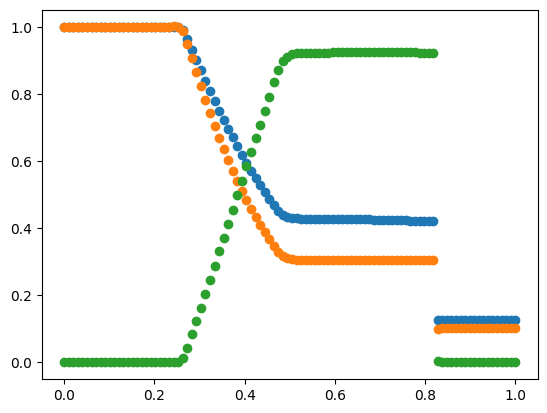

In [4]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [147]:
new_array = np.array(u_pred[:,2])
#new_array = np.array(x)
file = open("p.txt", "w+")
content = str(new_array)
file.write(content)
file.close()


In [ ]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [ ]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [ ]:
#np.size(id_f)
x_int_train = np.hstack((t_int, x_int))    # Random (x,t) - vectorized
#np.size(x_int_train)
#np.size(x_int)
#np.size(t_int)

In [ ]:
def NewPoint(x,t):
    xl = -0.2
    xr = 1.8
    dgt = 0.0
    dg1 = np.array([])
    M = np.array([])
    N = np.size(x)
    L = np.array([])
    y = np.copy(x)
    for i in range(N):
        if i == 0:
            L = np.append(L,x[0]-xl)
            dgl = dg(x[0],t)
            dgr = dg(xl,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        elif i < N-1:
            L = np.append(L,x[i+1]-x[i])
            dgl = dg(x[i],t)
            dgr = dg(x[i+1],t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        else:
            L = np.append(L,xr-x[N-1])
            dgl = dg(x[N-1],t)
            dgr = dg(xr,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[N-1]
    for i in range(N):
        M = np.append(M,int((dg1[i]*L[i])/dgt*N+0.5))

    print("M")
  #  print(M)
  #  print("L")
  #  print(L)
    print("dg1")
    print(dg1)
    Mt = 0

    for i in range(N):
        if i ==0 and M[0] > 0:
            for j in range(int(M[0])):
                y[j] = (x[0] - xl)/M[0]*(j+1) + xl
        elif i < N-1 and M[i]> 0 and Mt<N:
            for j in range(int(M[i])):
                y[j+Mt] = (x[i] - x[i-1])/M[i]*(j+1) + x[i-1]
        elif i==N-1 and M[N-1] >0:
            for j in range(int(M[N-1])):
                y[j+Mt] = (xr - x[N-1])/M[N-1]*(j+1) + x[N-1]
        
        Mt = Mt + int(M[i])
    return dg1



In [ ]:
x = np.linspace(-0.2, 1.8, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                   # Partitioned spatial axis

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
i=0
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x[0:99],t[99])
    t_r[i*100:99+i*100] =t[i]

In [ ]:
x_r[600:699]

In [ ]:
plt.scatter(x[0:99],x_r[0:99])

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x_r[i*100:99+i*100],t[i])
    #t_r[i*100:99+i*100] =t[i]

In [ ]:
t[0]

In [ ]:
T = t_r.flatten()[:, None]                                         # Vectorized t_grid
X = x_r.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain

In [ ]:

y =NewPoint(x,t[1])

In [ ]:
dg(1.8,0.2)

In [ ]:
def dg(x,t):
    y_t=np.array([[x]])
    t_t=np.array([[t]])
    x_t = np.hstack((y_t,t_t))

    x_t = torch.tensor(x_t, requires_grad=True, dtype=torch.float32).to(device)
    loss = model.loss_pde(x_t)                                    # Loss function of PDE
    y = model.net(x_t)                                                # Neural network
    rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
    drho_g = gradients(rho, x_t)[0]
    d = torch.tensor(drho_g, dtype=torch.float32).to(device1)
    return d.numpy()[0][0]


In [ ]:
x = np.linspace(-0.2, 1.8, 1000)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test1 = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred1 = to_numpy(model(x_test1))

In [ ]:

plt.plot(x[:],u_pred[:,0])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:],u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [ ]:
y = model.net(x_int_train)                                                # Neural network
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
drho_g = gradients(rho, x_int_train)[0]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [58]:
#device1 = torch.device('cpu')                                          # Run on CPU
torch.save(model,'1.pt')

In [ ]:
device = torch.device("cuda")
#model.load_state_dict(torch.load(PATH))
model.to(device)

# 文件读取模型

In [148]:
torch.save(model,'1.pt')


In [62]:
model = torch.load('1.pt')

In [ ]:

import matplotlib.pyplot as plt
x = np.linspace(-8.0 / 28.0, 20.0 / 28.0, num_x)  # Partitioned spatial axis
t = np.linspace(2.0, 2.0, 1)  # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)  # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]  # Vectorized t_grid
X = x_grid.flatten()[:, None]  # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to('cpu')
u_pred = to_numpy(model(x_test))
plt.plot(x,u_pred[:,0])
plt.plot(x,u_pred[:,1])
plt.plot(x,u_pred[:,2])
plt.plot(x,u_pred[:,3])
plt.plot(x,u_pred[:,4])

In [ ]:

plt.plot(x,u_pred[:,4])

In [ ]:
#u_pred[:,0]
import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
def fun(x):
    return x.mean()

fun([1,2,3,4;1,2,3,4])

In [ ]:
(1,2,3,4).mean()

In [ ]:
p = np.zeros(100)

In [ ]:
p.mean()